## MNIST by ResMLP

## TRAIN

### Import some necessary packages

In [1]:
import os
import sys
import time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torchvision
import torchvision.transforms as transforms
from einops.layers.torch import Rearrange
from tqdm.notebook import tqdm
import IPython.display as display
%matplotlib inline
from matplotlib import pyplot as plt

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

### Build the ResMLP

In [2]:
class Aff(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.alpha = nn.Parameter(torch.ones([1, 1, dim]))
        self.beta = nn.Parameter(torch.zeros([1, 1, dim]))

    def forward(self, x):
        x = x * self.alpha + self.beta
        return x

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

class MLPblock(nn.Module):

    def __init__(self, dim, num_patch, mlp_dim, dropout = 0., init_values=1e-4):
        super().__init__()
        self.pre_affine = Aff(dim)
        self.token_mix = nn.Sequential(
            Rearrange('b n d -> b d n'),
            nn.Linear(num_patch, num_patch),
            Rearrange('b d n -> b n d'),
        )
        self.ff = nn.Sequential(
            FeedForward(dim, mlp_dim, dropout),
        )
        self.post_affine = Aff(dim)
        self.gamma_1 = nn.Parameter(init_values * torch.ones((dim)), requires_grad=True)
        self.gamma_2 = nn.Parameter(init_values * torch.ones((dim)), requires_grad=True)

    def forward(self, x):
        x = self.pre_affine(x)
        x = x + self.gamma_1 * self.token_mix(x)
        x = self.post_affine(x)
        x = x + self.gamma_2 * self.ff(x)
        return x


class ResMLP(nn.Module):

    def __init__(self, in_channels, dim, num_classes, patch_size, image_size, depth, mlp_dim):
        super().__init__()
        assert image_size % patch_size == 0, 'Image dimensions must be divisible by the patch size.'
        self.num_patch =  (image_size// patch_size) ** 2
        self.to_patch_embedding = nn.Sequential(
            nn.Conv2d(in_channels, dim, patch_size, patch_size),
            Rearrange('b c h w -> b (h w) c'),
        )
        self.mlp_blocks = nn.ModuleList([])
        for _ in range(depth):
            self.mlp_blocks.append(MLPblock(dim, self.num_patch, mlp_dim))
        self.affine = Aff(dim)
        self.mlp_head = nn.Sequential(
            nn.Linear(dim, num_classes)
        )

    def forward(self, x):
        x = self.to_patch_embedding(x)
        for mlp_block in self.mlp_blocks:
            x = mlp_block(x)
        x = self.affine(x)
        x = x.mean(dim=1)
        return self.mlp_head(x)

### Setting some Paeameter

In [5]:
lr = 0.001  # learning rate
batch_size_train = 600  # batch_size for train
batch_size_test = 1000  # batch_size for test
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch
all_epochs = 100  # total epoch

### Setting GPU or CPU

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### Preparing Data

In [6]:
def prepare_data():
    global trainset, trainloader, testset, testloader
    print('==> Preparing data..')
    transform_train = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
    ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
    ])

    trainset = torchvision.datasets.MNIST(
        root='./data', train=True, download=False, transform=transform_train)
    trainloader = torch.utils.data.DataLoader(
        trainset, batch_size=batch_size_train, shuffle=True, num_workers=2)

    testset = torchvision.datasets.MNIST(
        root='./data', train=False, download=False, transform=transform_test)
    testloader = torch.utils.data.DataLoader(
        testset, batch_size=batch_size_test, shuffle=False, num_workers=2)

### Setting the Model

In [7]:
def set_model():
    global net, optimizer, criterion, start_epoch, best_acc, train_loss_list, test_loss_list, train_acc_list, test_acc_list
    print('==> Building model..')
    net = ResMLP(in_channels=1, image_size=28, patch_size=7, num_classes=10, dim=384, depth=2, mlp_dim=384*4)
    net = net.to(device)
    if device == 'cuda':
        net = torch.nn.DataParallel(net)
        cudnn.benchmark = True

    resume_flag = input("Whether to continue training?(Y/N)\n")
    train_loss_list = []
    test_loss_list = []
    train_acc_list = []
    test_acc_list = []
    if (resume_flag == "Y") or (resume_flag == "y"):
        # Load checkpoint.
        print('==> Resuming from checkpoint..')
        assert os.path.isdir('checkpoint'), 'Error: no checkpoint directory found!'
        last_checkpoint = torch.load('./checkpoint/mnist_resmlp_last.pth')
        best_checkpoint = torch.load('./checkpoint/mnist_resmlp_best.pth')
        net.load_state_dict(last_checkpoint['net'])
        best_acc = best_checkpoint['acc']
        start_epoch = last_checkpoint['epoch'] + 1
        train_loss_list = last_checkpoint['trainloss']
        test_loss_list = last_checkpoint['testloss']
        train_acc_list = last_checkpoint['trainacc']
        test_acc_list = last_checkpoint['testacc']

    criterion = F.cross_entropy
    optimizer = optim.Adam(net.parameters(), lr=lr)

### Training

In [8]:
def train(epoch):
    global train_loss_list, train_acc_list
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    pbar = tqdm(enumerate(trainloader), desc=f'TRAIN Epoch {epoch}',total=len(trainloader))
    for batch_idx, (inputs, targets) in pbar:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        pbar.set_postfix({"Loss":f"{(train_loss/(batch_idx+1)):.3f}","Acc":f"{100*correct/total:.3f} ({correct}/{total})"})
    train_loss_list.append(train_loss/len(trainloader))
    train_acc_list.append(correct/total)

### Testing

In [9]:
def test(epoch):
    global best_acc, test_loss_list, test_acc_list
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        pbar = tqdm(enumerate(testloader), desc=f'TEST Epoch {epoch}',total=len(testloader))
        for batch_idx, (inputs, targets) in pbar:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            pbar.set_postfix({"Loss":f"{(test_loss/(batch_idx+1)):.3f}","Acc":f"{100*correct/total:.3f} ({correct}/{total})"})

    # Save checkpoint.
    test_loss_list.append(test_loss/len(testloader))
    test_acc_list.append(correct/total)
    acc = 100.*correct/total
    print('Saving the last..')
    state = {
        'net': net.state_dict(),
        'acc': acc,
        'epoch': epoch,
        'trainloss':train_loss_list,
        'testloss':test_loss_list,
        'trainacc':train_acc_list,
        'testacc':test_acc_list,
    }

    if not os.path.isdir('checkpoint'):
        os.mkdir('checkpoint')
    torch.save(state, './checkpoint/mnist_resmlp_last.pth')
    print("The last Acc:" + str(acc))
    if acc > best_acc:
        print('Saving the best..')
        state = {
            'net': net.state_dict(),
            'acc': acc,
            'epoch': epoch,
            'trainloss':train_loss_list,
            'testloss':test_loss_list,
            'trainacc':train_acc_list,
            'testacc':test_acc_list,
        }
 
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/mnist_resmlp_best.pth')
        best_acc = acc
    print("The best Acc:" + str(best_acc))

### Plot Loss & Accuray

In [10]:
def plot(epoch):
    epoch_list = list(range(0, epoch))
    plt.plot(epoch_list, train_loss_list, label="train_loss")
    plt.plot(epoch_list, test_loss_list, label="test_loss")
    plt.plot(epoch_list, train_acc_list, label="train_accuracy")
    plt.plot(epoch_list, test_acc_list, label="test_accuracy")
    plt.scatter(np.argmin(train_loss_list), np.min(train_loss_list), label="min train loss")
    plt.scatter(np.argmin(test_loss_list), np.min(test_loss_list), label="min test loss")
    plt.scatter(np.argmax(train_acc_list), np.max(train_acc_list), label="max train accuracy")
    plt.scatter(np.argmax(test_acc_list), np.max(test_acc_list), label="max test accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Loss/Accuracy")
    plt.grid()
    plt.show()

### Main

In [11]:
prepare_data()
set_model()

==> Preparing data..
==> Building model..


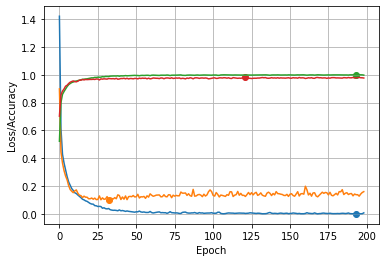

TRAIN Epoch 199:   0%|          | 0/100 [00:00<?, ?it/s]

TEST Epoch 199:   0%|          | 0/10 [00:00<?, ?it/s]

Saving the last..
The last Acc:97.86
The best Acc:98.08


In [12]:
for epoch in range(start_epoch, start_epoch + all_epochs):
    if epoch > 0:
        plot(epoch)
    train(epoch)
    test(epoch)
    display.clear_output(wait=True)

### Final plot Loss & Accuray

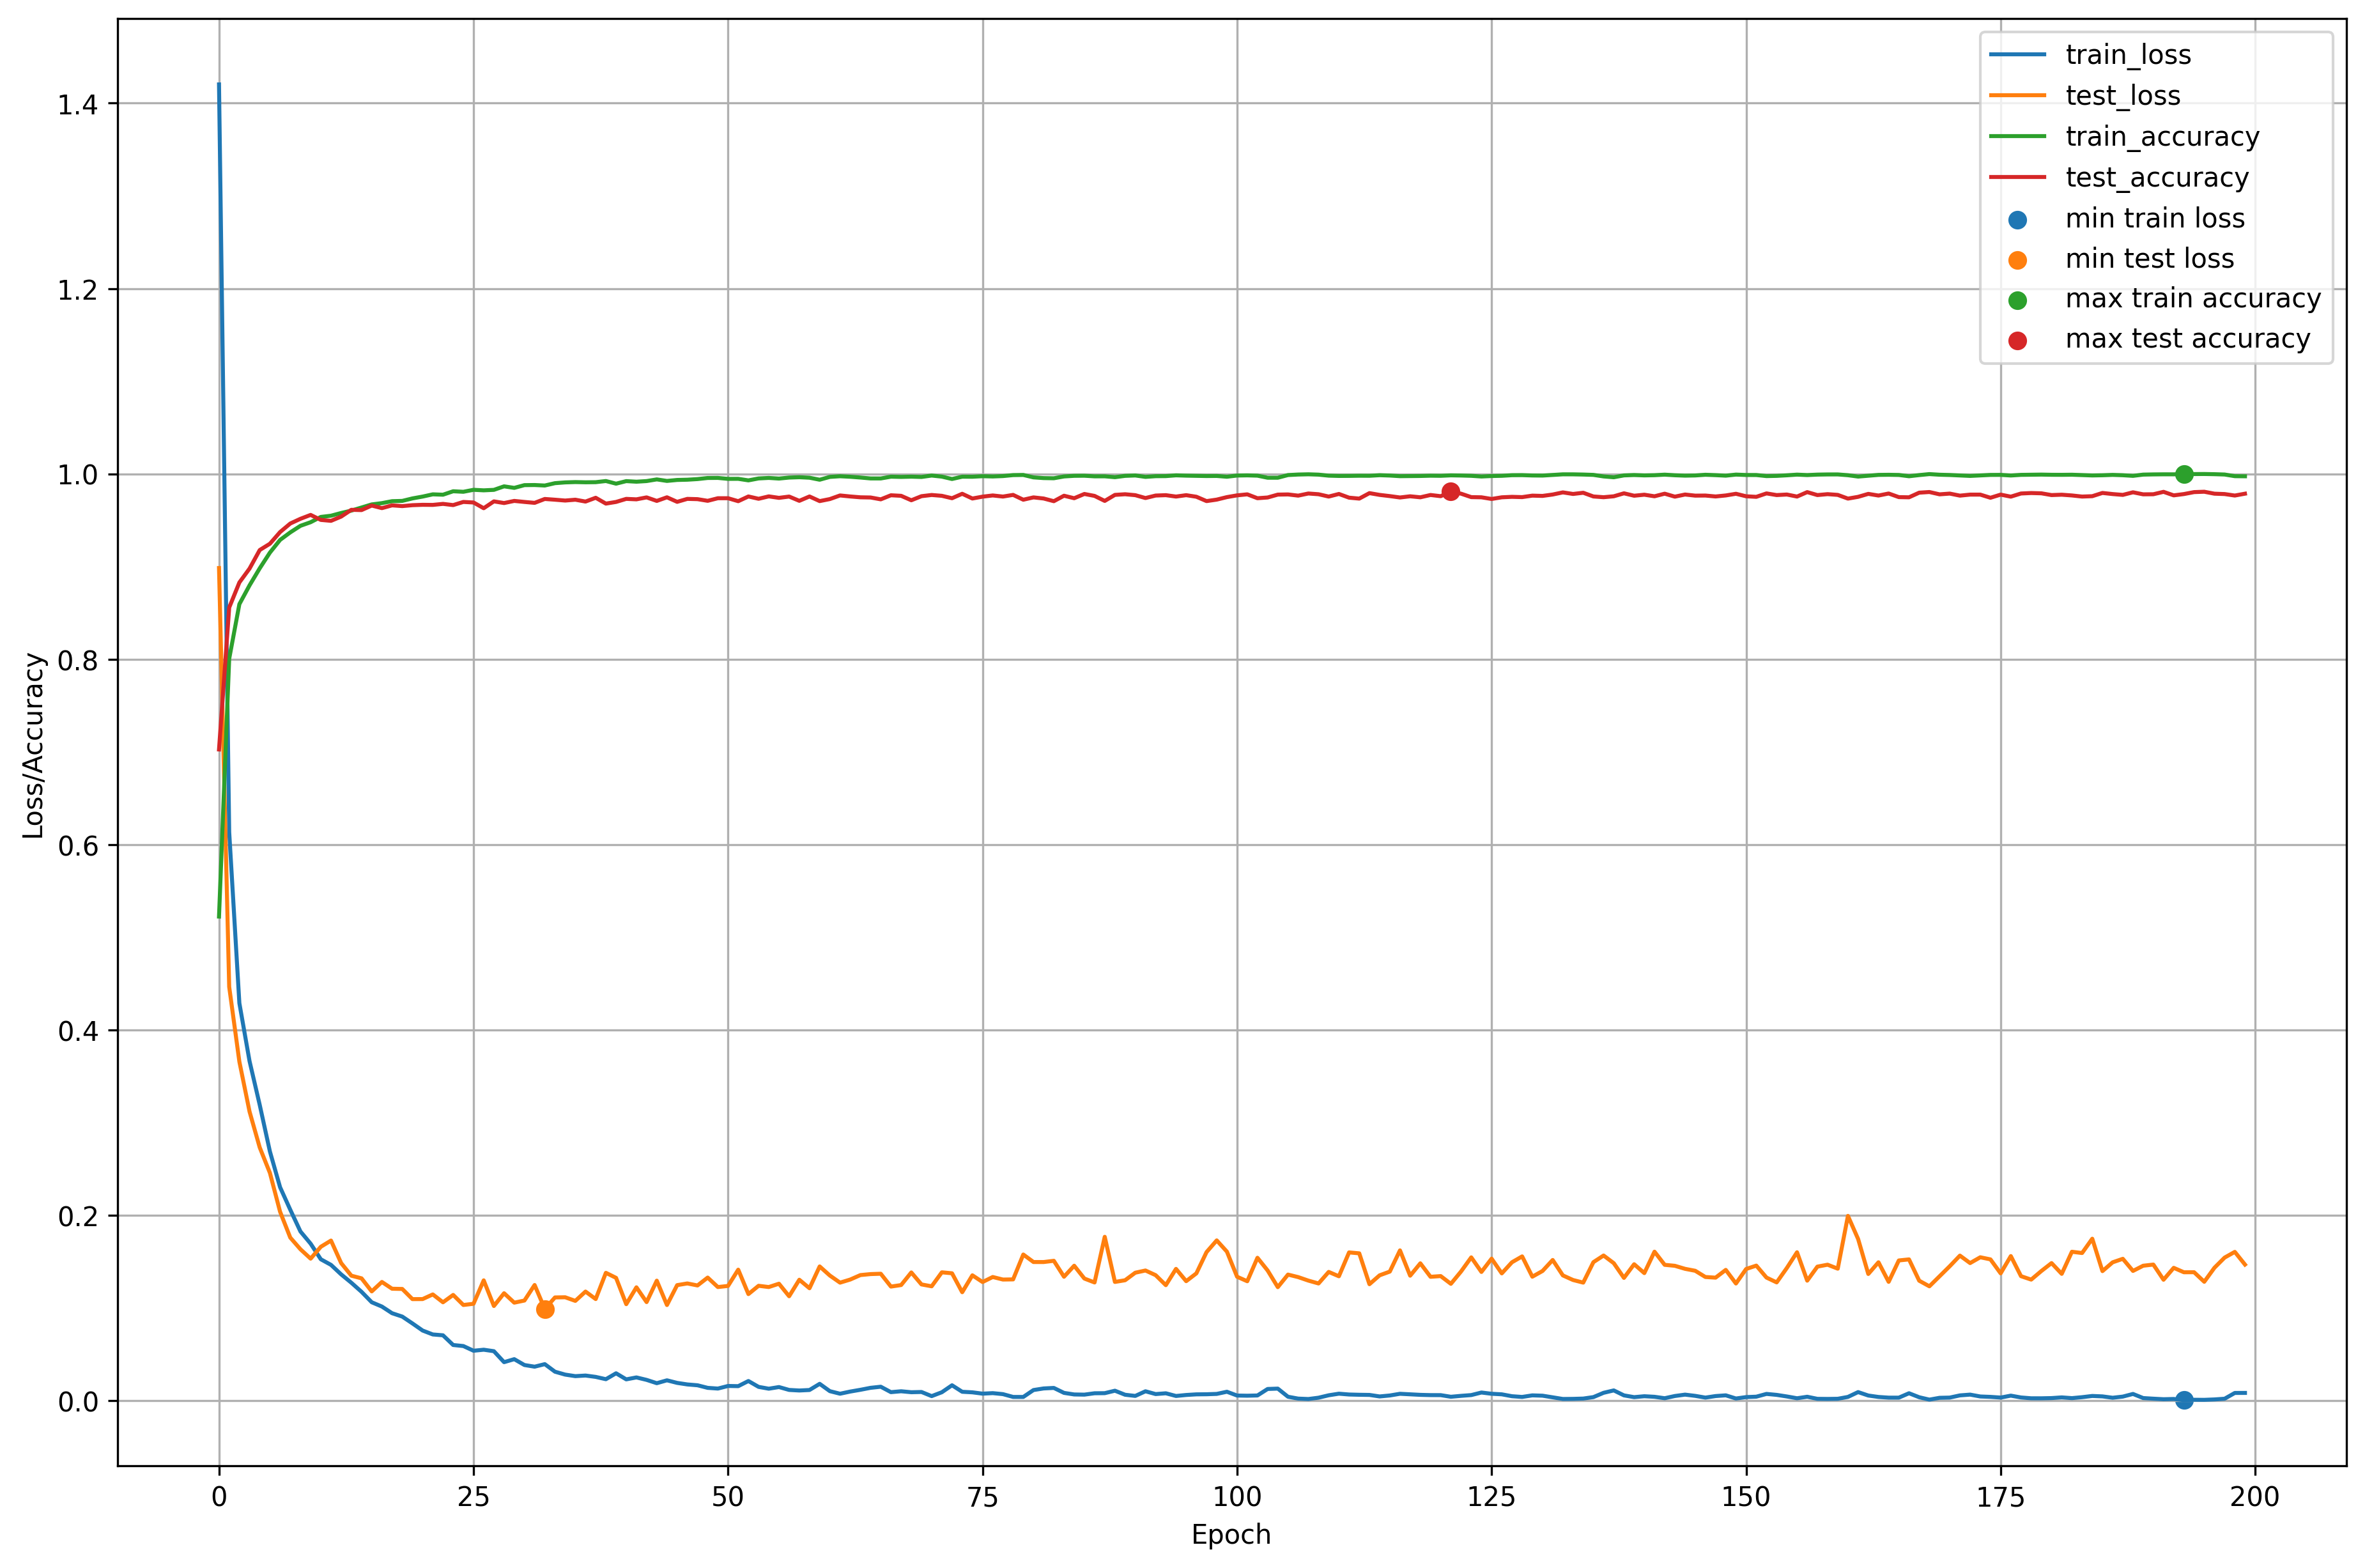

In [13]:
last_checkpoint = torch.load('./checkpoint/mnist_resmlp_last.pth')
start_epoch = last_checkpoint['epoch'] + 1
train_loss_list = last_checkpoint['trainloss']
test_loss_list = last_checkpoint['testloss']
train_acc_list = last_checkpoint['trainacc']
test_acc_list = last_checkpoint['testacc']

epoch_list = list(range(0, start_epoch))

plt.figure(figsize=(15, 10), dpi=300)
plt.plot(epoch_list, train_loss_list, label="train_loss")
plt.plot(epoch_list, test_loss_list, label="test_loss")
plt.plot(epoch_list, train_acc_list, label="train_accuracy")
plt.plot(epoch_list, test_acc_list, label="test_accuracy")
plt.scatter(np.argmin(train_loss_list), np.min(train_loss_list), label="min train loss")
plt.scatter(np.argmin(test_loss_list), np.min(test_loss_list), label="min test loss")
plt.scatter(np.argmax(train_acc_list), np.max(train_acc_list), label="max train accuracy")
plt.scatter(np.argmax(test_acc_list), np.max(test_acc_list), label="max test accuracy")
plt.xlabel("Epoch")
plt.ylabel("Loss/Accuracy")
plt.grid()
plt.legend()
plt.show()